In [1]:
from tqdm.notebook import tqdm
from os.path import isfile

import h5py
import numpy as np
import matplotlib.pyplot as plt
from lib_main_transient import case_config

from femvf import load, statefile as sf
from femvf.models import solid as smd, fluid as fmd
from femvf.signals.solid import make_sig_glottal_width_sharp

import h5utils

In [11]:
# global configuration
ZETA = 1e-4
R_SEP = 1.0
Y_GAP = 1e-2
PSUBS = np.concatenate([np.arange(200, 300, 10), np.arange(300, 1000, 100)])*10
ECOV = 5e3 * 10
EBODY = 15e3 * 10
EBODY = 5e3 * 10

INIT_STATE_TYPE = 'static'

OUT_DIR = f'out/zeta{ZETA:.2e}_rsep{R_SEP:.1f}_ygap{Y_GAP:.2e}_init{INIT_STATE_TYPE}'

mesh_name = 'BC-dcov5.00e-02-cl1.00'
mesh_path = f'mesh/{mesh_name}.xml'
model = load.load_fsi_model(mesh_path, None, SolidType=smd.KelvinVoigt, FluidType=fmd.Bernoulli, coupling='explicit')

In [12]:
glottal_width = make_sig_glottal_width_sharp(model)

def time(f):
    return np.array(f.get_times())

In [13]:
## Post processing script
postprocess_fname = f'{OUT_DIR}/data.h5'

case_to_data = {}
if isfile(postprocess_fname):
    with h5py.File(postprocess_fname, mode='r') as f:
        case_to_data = h5utils.h5_to_dict(f, case_to_data)

signal_to_proc = {
    'glottal_width': glottal_width,
    'time': time}

case_to_data_update = {}
for psub in tqdm(PSUBS):
    case = case_config(mesh_name, psub, ECOV, EBODY)
    file_path = f'{OUT_DIR}/{case}.h5'
    # with sf.StateFile(model, file_path, mode='r') as f:
    #     print(f.get_properties()['ycontact'])
    #     print(f.get_properties()['kcontact'])
    #     print(f.get_properties()['zeta_amin'])
    #     print(f.get_properties()['zeta_sep'])
    #     print(f.get_properties()['r_sep'])
    #     print(f.get_properties()['ygap_lb'])
    #     print()
    
    for signame, proc in signal_to_proc.items():
        key = f'{case}/{signame}'
        if key not in case_to_data and isfile(file_path):
            with sf.StateFile(model, file_path, mode='r') as f:
                case_to_data_update[key] = proc(f)
        
with h5py.File(postprocess_fname, mode='a') as f:       
    h5utils.dict_to_h5(case_to_data_update, f)
    
case_to_data.update(case_to_data_update)

  0%|          | 0/17 [00:00<?, ?it/s]

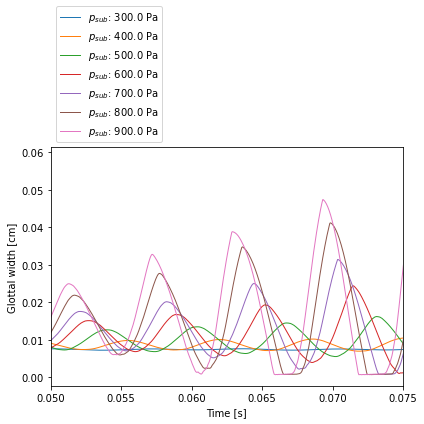

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for psub in PSUBS[10:]:
    try:
        case = case_config(mesh_name, psub, ECOV, EBODY)
        t = case_to_data[f'{case}/time']
        gw = case_to_data[f'{case}/glottal_width']
        ax.plot(t, gw, label=f"$p_{{sub}}$: {psub/10:.1f} Pa", lw=1.0)
    except:
        pass
    
# ax.set_xlim(0.49, 0.5)

t0 = 0.05
ax.set_xlim(t0, t0+0.025)
# ax.set_xlim(0, 0.1)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Glottal width [cm]")

ax.legend(loc='lower left', bbox_to_anchor=(0, 1))

fig.tight_layout()
fig.savefig(f'{OUT_DIR}/TransientSimulation.png')